# 21 - Meta Learners

Pour récapituler, nous nous intéressons maintenant à trouver l'hétérogénéité des effets du traitement, c'est-à-dire à identifier comment les unités réagissent différemment au traitement. Dans ce cadre, nous voulons estimer

$$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$$

ou $E[\delta Y_i(t)|X]$ dans le cas continu. En d'autres termes, nous voulons savoir à quel point les unités sont sensibles au traitement. Cela est particulièrement utile dans le cas où nous ne pouvons pas traiter tout le monde et devons prioriser le traitement, par exemple lorsque vous souhaitez accorder des réductions mais disposez d'un budget limité.

Précédemment, nous avons vu comment nous pouvions transformer la variable de résultat $Y$ afin de l'intégrer dans un modèle prédictif et obtenir une estimation de l'Effet Moyen Conditionnel du Traitement (CATE). Dans ce cas, nous avons dû payer un prix en termes d'augmentation de la variance. C'est quelque chose que nous voyons souvent en Data Science. Il n'existe pas de méthode unique parfaite car chacune a ses inconvénients et avantages. Pour cette raison, il vaut la peine d'apprendre de nombreuses techniques afin de pouvoir faire des compromis selon les circonstances. Dans cet esprit, ce chapitre se concentrera sur l'ajout de plus d'outils à votre disposition.

![img](data/img/meta-learners/learned-new-move.png)

Les meta learners sont un moyen simple de tirer parti des méthodes de machine learning prédictives prêtes à l'emploi pour résoudre le même problème que nous avons étudié jusqu'à présent : estimer le CATE. Encore une fois, aucun d'entre eux n'est le meilleur en soi, chacun ayant ses faiblesses. Je vais essayer de les passer en revue, mais gardez à l'esprit que ce sujet est fortement dépendant du contexte. De plus, les meta learners déploient des modèles de machine learning prédictifs qui peuvent varier de la régression linéaire aux arbres de décision boostés, en passant par les réseaux neuronaux et les processus gaussiens. Le succès du meta learner dépendra également fortement de la méthode de machine learning qu'il utilise comme composant. Souvent, il faut simplement essayer différentes approches et voir ce qui fonctionne le mieux.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast

Ici, nous allons utiliser les mêmes données que précédemment, concernant les emails publicitaires sur les investissements. Encore une fois, l'objectif est de déterminer qui réagira le mieux à l'email. Cependant, il y a une petite différence. Cette fois-ci, nous utiliserons des données non aléatoires pour entraîner les modèles et des données aléatoires pour les valider. Travailler avec des données non aléatoires est une tâche beaucoup plus difficile, car les meta learners devront à la fois débiaiser les données **ET** estimer le CATE.

In [2]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


Notre variable de résultat est la conversion et notre traitement est email-1. Créons des variables pour stocker celles-ci ainsi que les caractéristiques $X$ que nous utiliserons pour rechercher l'hétérogénéité de l'effet du traitement.

In [3]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

## S-Learner (aussi appelé le Go-Horse Learner)

Le premier learner que nous allons utiliser est le S-Learner. C'est le learner le plus simple auquel on puisse penser. Nous allons utiliser un seul modèle de machine learning $M_s$ (d'où le "S" pour "Single") pour estimer

$$
\mu(x) = E[Y| T, X]
$$

Pour ce faire, nous allons simplement inclure le traitement comme une caractéristique dans le modèle qui tente de prédire le résultat Y.

```note
Bien que j'utilise un régressseur pour estimer $E[Y| T, X]$, étant donné que la variable de résultat est binaire, vous pourriez également utiliser un classifieur. Assurez-vous simplement d'adapter le code pour que le modèle produise des probabilités au lieu de la classe binaire, 0 ou 1.
```

In [4]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train[X+[T]], train[y]);

Ensuite, nous pouvons faire des prédictions sous différents régimes de traitement. La différence entre les prédictions pour le groupe test et le groupe contrôle sera notre estimation du CATE

$$
\hat{\tau}(x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)
$$

Si nous représentons cela dans un diagramme, voici à quoi cela ressemblerait

![img](data/img/meta-learners/s-learner.png)

Voyons maintenant comment nous pouvons implémenter ce learner en code.

In [5]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

Pour évaluer ce modèle, nous allons examiner la courbe de gain cumulée sur le jeu de test. Je trace également la courbe de gain sur le jeu d'entraînement. Comme le jeu d'entraînement est biaisé, cette courbe ne peut pas indiquer si le modèle est bon, mais elle peut nous signaler si nous faisons du surapprentissage (overfitting) sur le jeu d'entraînement. Lorsque cela se produit, la courbe sur le jeu d'entraînement sera extrêmement élevée. Si vous voulez voir à quoi cela ressemble, essayez de remplacer le paramètre `max_depth` de 3 à 20.

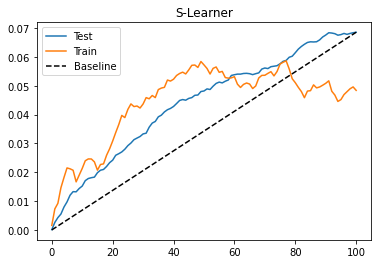

In [6]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");

![img](data/img/meta-learners/not-great-not-terrible.jpeg)

Comme nous pouvons le voir sur la courbe de gain cumulée, le S-learner, bien que simple, peut donner des résultats corrects sur ce jeu de données. Il est important de garder à l'esprit que cette performance est très spécifique à ce jeu de données. Selon le type de données que vous avez, le S-learner peut mieux ou moins bien fonctionner. En pratique, je trouve que le S-learner est un bon premier choix pour tout problème causal, principalement en raison de sa simplicité. De plus, le S-learner peut gérer à la fois les traitements continus et discrets, tandis que les autres learners de ce chapitre ne peuvent traiter que les traitements discrets.

Le principal inconvénient du S-learner est qu'il a tendance à biaiser l'effet du traitement vers zéro. Étant donné que le S-learner utilise généralement un modèle de machine learning régularisé, cette régularisation peut limiter l'effet du traitement estimé. ‪Chernozhukov‬ et al (2016) décrivent ce problème en utilisant des données simulées :

![img](data/img/meta-learners/zero-bias-s-learner.png)

Ici, ils tracent la différence entre l'effet causal réel (contour rouge) et l'effet causal estimé, $\tau - \hat{\tau}$, en utilisant un S-learner. L'effet causal estimé est fortement biaisé.

Encore pire, si le traitement est très faible par rapport à l'impact d'autres covariables dans l'explication du résultat, le S-learner peut complètement ignorer la variable de traitement. Notez que cela est fortement lié au modèle de machine learning que vous utilisez. Plus la régularisation est forte, plus le problème est important. Une tentative de remédier à cela est le prochain learner que nous allons voir.

## T-Learner

Le T-learner tente de résoudre le problème de l'abandon total du traitement en forçant le learner à d'abord se scinder sur celui-ci. Au lieu d'utiliser un seul modèle, nous allons utiliser un modèle par variable de traitement. Dans le cas binaire, il n'y a que deux modèles à estimer (d'où le nom T) :

$$
\mu_0(x) = E[Y| T=0, X]
$$

$$
\mu_1(x) = E[Y| T=1, X]
$$

Ensuite, au moment de la prédiction, nous pouvons faire des prédictions contrefactuelles pour chaque traitement et obtenir le CATE comme suit :

$$
\hat{\tau}(x)_i = M_1(X_i) - M_0(X_i)
$$

Voici le diagramme de ce learner :

![img](data/img/meta-learners/t-learner.png)

Maintenant, assez de théorie. Passons au code.

In [7]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

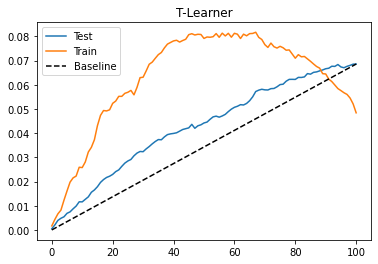

In [8]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner");

Le T-learner donne également des résultats corrects sur ce jeu de données. La performance sur le jeu de test ne semble pas très différente de celle obtenue avec le S-learner, peut-être parce que le traitement n'est pas si faible. De plus, nous pouvons voir que la performance sur le jeu d'entraînement est bien plus élevée que celle sur le jeu de test, ce qui indique que le modèle fait du surapprentissage (overfitting). Cela peut se produire parce que nous ajustons chaque modèle sur seulement une partie des données. Avec moins de points de données, le modèle apprend probablement du bruit.

Le T-learner évite le problème de ne pas détecter une variable de traitement faible, mais il peut encore souffrir du biais de régularisation. Considérons la situation suivante, tirée de Kunzela et al., 2019. Vous avez beaucoup de données pour les non-traités et très peu de données pour les traités, un cas assez courant dans de nombreuses applications, car le traitement est souvent coûteux. Supposons maintenant que vous ayez une certaine non-linéarité dans le résultat Y, mais que **l'effet du traitement soit constant**. Voyons ce qui se passe dans l'image suivante :

![img](data/img/meta-learners/t-learner-problem.png)

Ici, comme nous avons très peu d'observations traitées, $M_1$ sera un modèle très simple (linéaire dans ce cas) pour éviter le surapprentissage. $M_0$ sera plus complexe, mais c'est acceptable car l'abondance de données empêche le surapprentissage. Tout cela est raisonnable d'un point de vue Machine Learning. Cependant, si nous utilisons ces modèles pour calculer le CATE $\hat{\tau}=M_1(X) - M_0(X)$, la linéarité de $M_1(X)$ moins la non-linéarité de $M_0(X)$ entraînera un CATE non linéaire (ligne bleue moins ligne rouge), ce qui est incorrect, puisque le CATE est constant et égal à 1 dans ce cas.

Ce qui se passe ici, c'est que le modèle pour les non-traités peut détecter la non-linéarité, mais le modèle pour les traités ne le peut pas, car nous avons utilisé la régularisation pour gérer une petite taille d'échantillon. Bien sûr, vous pourriez utiliser moins de régularisation sur ce modèle, mais alors la petite taille d'échantillon entraînerait un surapprentissage. Il semble que nous soyons pris entre le marteau et l'enclume. Pour résoudre ce problème, nous pouvons utiliser un X-learner, proposé dans le même article par Kunzela et al.

## X-Learner

Le X-learner est nettement plus complexe à expliquer que le learner précédent, mais son implémentation est assez simple, donc ne vous inquiétez pas. Le X-Learner comporte deux étapes et un modèle de score de propension. La première étape est identique à celle du T-learner. Tout d'abord, nous séparons les échantillons en traités et non traités et ajustons un modèle de ML pour les traités et pour les contrôles.

$$
\hat{M}_0(X) \approx E[Y| T=0, X]
$$

$$
\hat{M}_1(X) \approx E[Y| T=1, X]
$$

Maintenant, les choses commencent à changer. Pour la deuxième étape, nous imputons l'effet du traitement pour les contrôles et pour les traités en utilisant les modèles ci-dessus

$$
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$$

$$
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$$

Ensuite, nous ajustons deux autres modèles pour prédire ces effets

$$
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$$

$$
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$$

Si nous appliquons cela à l'image que nous avons montrée précédemment, $\hat{\tau}(X, T=0)$, l'effet du traitement imputé pour les non-traités, serait les croix rouges, et la ligne rouge pointillée serait $\hat{M}_{\tau 0}(X)$. Remarquez que ce modèle est incorrect. Comme $\hat{\tau}(X, T=0)$ a été obtenu en utilisant le modèle régularisé et simple, estimé sur les traités, $\hat{M}_1$. L'effet du traitement qu'il impute est non linéaire, car il **ne** capture **pas** la non-linéarité dans la variable Y.

En revanche, les points bleus sont l'effet du traitement imputé pour les traités, $\hat{\tau}(X, T=1)$. Ces effets sont estimés en utilisant le modèle correct, $M_0$, entraîné sur l'échantillon non traité, qui est large. En conséquence, puisque les effets du traitement imputés sont corrects, nous sommes capables d'entraîner un modèle de deuxième étape correct $\hat{M}_{\tau 1}(X)$, représenté par la ligne bleue.

![img](data/img/meta-learners/second-stage-x.png)

Nous avons donc un modèle qui est incorrect parce que nous avons mal imputé les effets du traitement et un autre modèle qui est correct parce que nous avons imputé ces valeurs correctement. Nous avons maintenant besoin d'un moyen de combiner les deux de manière à donner plus de poids au modèle correct. C'est ici que le modèle de score de propension entre en jeu. Soit $\hat{e}(x)$ le modèle de score de propension, nous pouvons combiner les deux modèles de deuxième étape comme suit :

$$
\hat{\tau(x)} = \hat{M}_{\tau 0}(X)\hat{e}(x) +  \hat{M}_{\tau 1}(X)(1-\hat{e}(x))
$$

Étant donné qu'il y a très peu d'unités traitées, $\hat{e}(x)$ est très faible. Cela donnera un poids très faible au modèle incorrect $\hat{M}_{\tau 0}(X)$.

En revanche, $1-\hat{e}(x)$ est proche de un, donc nous donnerons un poids élevé au modèle correct $\hat{M}_{\tau 1}(X)$. Plus généralement, la moyenne pondérée utilisant le score de propension garantit que nous donnons plus de poids au modèle CATE qui a été estimé là où le traitement assigné était le plus probable. En d'autres termes, nous privilégierons le modèle qui a été entraîné avec plus de données. L'image suivante montre le CATE estimé par le X-learner et le T-learner.

![img](data/img/meta-learners/t-vs-x-learner.png)

Comme nous pouvons le voir, comparé au T-learner, le X-learner corrige bien mieux le CATE erroné estimé au niveau de la non-linéarité. En général, le X-learner fonctionne mieux lorsqu'un groupe de traitement est beaucoup plus grand que l'autre.

Je sais que cela peut sembler complexe, mais tout devrait devenir plus clair lorsque nous passerons à l'implémentation. Pour résumer, voici le diagramme de ce learner.

![img](data/img/meta-learners/x-learner.png)

Passons enfin au code ! Tout d'abord, nous avons la première étape, qui est exactement la même que celle du T-Learner.

In [9]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty='none') 

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])
                       
g.fit(train[X], train[T]);

Maintenant, nous imputons l'effet du traitement et ajustons les modèles de deuxième étape sur ceux-ci.

In [10]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

Enfin, nous faisons des prédictions corrigées en utilisant le modèle de score de propension.  

In [11]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
    
x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

Voyons comment notre X-Learner se comporte sur le jeu de test. Encore une fois, traçons la courbe de gain cumulée.

/Users/matheus.facure/Documents/python-causality-handbook/causal-inference-for-the-brave-and-true/nb21.py:10: RuntimeWarning: invalid value encountered in double_scalars
  np.sum((data[t] - data[t].mean())**2))


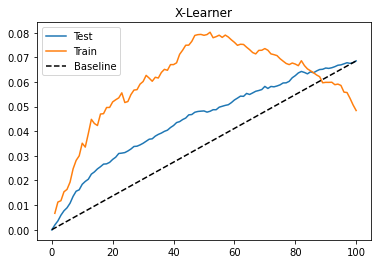

In [12]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");

Une fois de plus, nous obtenons une performance correcte sur ce jeu de données. Ici, les learners S, T et X semblent avoir des performances assez similaires. Cependant, je pense qu’il est important de connaître tous ces meta learners afin de pouvoir utiliser celui qui fonctionne le mieux pour vous. Gardez à l’esprit que la performance dépend également fortement du modèle de machine learning de base que nous choisissons. Ici, nous avons tout fait en utilisant des Gradient Boosted Trees, mais peut-être qu’autre chose, ou même la même chose avec des hyperparamètres différents, pourrait mieux fonctionner.
 
## Key Ideas
 
Encore une fois, la chose la plus simple que nous puissions faire est d’utiliser un seul modèle ou S-learner avec le traitement comme caractéristique. Cela tend à bien fonctionner lorsque le traitement n’est pas un prédicteur faible du résultat. Mais si ce n’est pas le cas, le S-learner a tendance à être biaisé vers zéro ou même à abandonner complètement le traitement. En ajoutant un peu plus de complexité, nous pouvons forcer le learner à prendre en compte le traitement en utilisant un T-learner. Ici, nous ajustons un modèle de machine learning par niveau de traitement. Cela fonctionne bien lorsqu’il y a suffisamment d’échantillons pour tous les niveaux de traitement, mais cela peut échouer lorsqu’un niveau de traitement a une petite taille d’échantillon, ce qui oblige le modèle à être fortement régularisé. Pour remédier à cela, nous pouvons ajouter un autre niveau de complexité en utilisant un X-learner, où nous avons deux étapes d’ajustement et nous utilisons un modèle de score de propension pour corriger les erreurs potentielles des modèles estimés avec très peu de points de données.

Un grand problème de ces learners (à l’exception du S-learner) est qu’ils supposent un traitement binaire ou catégoriel. Il existe un autre learner que nous n’avons pas encore vu, qui est plus général : le R-learner. Mais ne vous inquiétez pas, nous y consacrerons un chapitre entier.
 
## Références

Les choses que j'ai écrites ici viennent principalement de ma propre expérience. Je les ai apprises par la pratique. Cela signifie qu'il n'y a pas de référence directe à laquelle je peux vous renvoyer. Cela signifie aussi que ce que j'ai écrit ici n'a **pas** été soumis à l'examen académique que la bonne science traverse souvent. Au lieu de cela, remarquez comment je parle de choses qui fonctionnent dans la pratique, mais je ne passe pas trop de temps à expliquer pourquoi cela est le cas. C'est une sorte de science de la rue, si vous voulez. Cependant, je mets cela à la disposition du public pour examen, donc, si vous trouvez quelque chose d'absurde, ouvrez un problème et je le traiterai au mieux de mes efforts.

Pour écrire ce chapitre, je me suis appuyé sur la bibliothèque *causalml* d’Uber et leur documentation sur les meta learners. J’ai également pris de nombreuses images et concepts de Kunzela et al. (2019), *Metalearners for estimating heterogeneous treatment effects using machine learning*. Enfin, la discussion sur le biais du S-learner vers zéro a été tirée de Chernozhukov et al. (2017), *Double/Debiased Machine Learning for Treatment and Causal Parameters*.

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).